In [1]:
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import pandas as pd
import pickle
import os
import seaborn as sns
import glob


In [2]:
# Connecting to Google Drive and mount project to running instance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Need to manually set project path.
fpath='/content/drive/MyDrive/Colab Notebooks/Capstone'

print(f"Project filepath, fpath: {fpath}")

Project filepath, fpath: /content/drive/MyDrive/Colab Notebooks/Capstone


## Daily forecasts, for 2019-01-01 to 2019-12-31, compared to test data

In [4]:
fpathx=fpath+'/model_runs'

reslist=[]
for i in range(1,9):
    dd=pd.read_pickle(fpathx+f'/m_{i}/dict_MASE_MAE_{i}.pkl')
    dict_M=dd['dict_M']
    for k,v in dict_M.items():
        reslist.append(k[0].split('_')+[k[1],v['mase_test'],v['mase_test2'],v['mae_test'],v['mae_test_rel'],v['rmse_test']])

df_res=pd.DataFrame(data=reslist,columns=['Station','Product','model','mase_test','mase_test2','mae_test','mae_test_rel','rmse_test'])

model_names={1:'Seasonal\nNeuralProphet',2:'Seasonal+AR',3:'Seasonal\n+AR-Net',4:'Seasonal\n+AR-Net+Meteo',
             5:'Seasonal\n+AR+$\Delta$y',6:'Seasonal+AR+\n$\Delta$y+Meteo',
             7:'Seasonal+AR+\n$\Delta$y+Meteo\n+$\Delta$PVP',8:'Seasonal+AR+\n$\Delta$y+Meteo\n+$\Delta$PVP+nearby $\Delta$PVP'}

df_res['model_name']=df_res.model.map(model_names)

ms=[model_names[i] for i in model_names.keys() if i>0 and i<9]

In [5]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #FF8200;font-weight:bold' if v else '' for v in is_min]


print("95 1d forecast minimum MAE % for each station")
df_res.groupby(['Station','model','Product']).mae_test_rel.min().unstack().unstack()['95']\
      .style.format('{:.1%}')\
      .apply(highlight_min,axis=1)


95 1d forecast minimum MAE % for each station


model,1,2,3,4,5,6,7,8
Station,,,,,,,,
ES1,31.1%,28.6%,27.5%,24.5%,23.7%,19.9%,23.4%,26.0%
ES10,11.8%,11.7%,14.6%,11.0%,13.6%,11.8%,15.3%,12.2%
ES11,11.9%,14.5%,16.5%,14.3%,15.8%,14.1%,15.8%,14.9%
ES12,15.1%,14.4%,14.8%,15.7%,15.4%,13.0%,15.1%,14.9%
ES2,22.2%,23.0%,22.3%,21.2%,22.4%,23.0%,22.2%,22.8%
ES3,29.1%,26.5%,22.4%,24.7%,27.3%,25.8%,24.2%,25.4%
ES4,27.3%,14.8%,18.3%,15.3%,20.1%,14.3%,14.9%,18.9%
ES5,38.1%,36.0%,32.0%,29.7%,38.2%,26.7%,36.8%,37.4%
ES6,17.8%,12.4%,17.3%,17.1%,13.7%,13.9%,12.4%,12.5%


In [6]:
print("GOA 1d forecast minimum MAE % for each station")
df_res.groupby(['Station','model','Product']).mae_test_rel.min().unstack().unstack()['GOA']\
      .style.format('{:.1%}')\
      .apply(highlight_min,axis=1)


GOA 1d forecast minimum MAE % for each station


model,1,2,3,4,5,6,7,8
Station,,,,,,,,
ES1,12.9%,14.0%,15.9%,14.2%,14.3%,14.9%,13.7%,14.8%
ES10,20.4%,16.3%,17.4%,16.5%,14.2%,14.6%,13.6%,16.7%
ES11,14.0%,15.4%,18.7%,31.3%,20.6%,15.6%,15.6%,15.7%
ES12,18.3%,20.7%,25.8%,19.0%,19.4%,23.3%,22.0%,18.9%
ES2,19.9%,15.7%,21.1%,17.5%,11.0%,14.9%,16.1%,17.2%
ES3,21.0%,19.6%,23.4%,21.9%,19.1%,20.4%,27.1%,21.0%
ES4,16.9%,16.6%,20.1%,16.3%,14.9%,17.8%,16.9%,16.8%
ES5,18.5%,19.0%,20.7%,20.8%,19.1%,19.8%,18.6%,20.2%
ES6,15.3%,15.5%,20.9%,15.7%,14.9%,15.9%,16.2%,17.5%


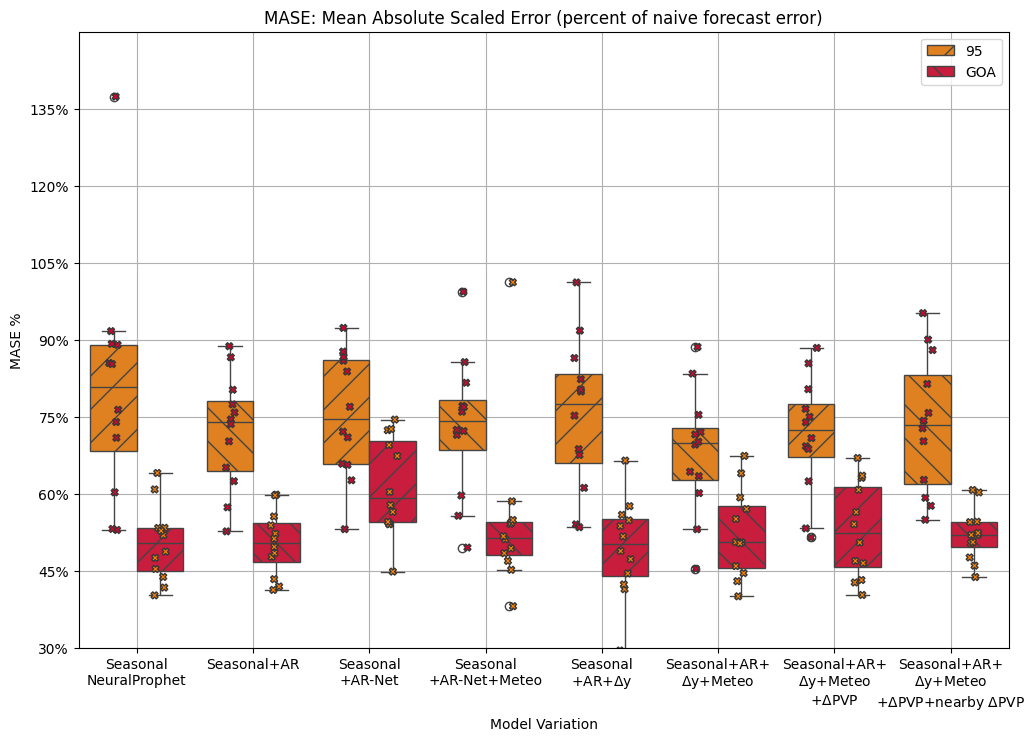

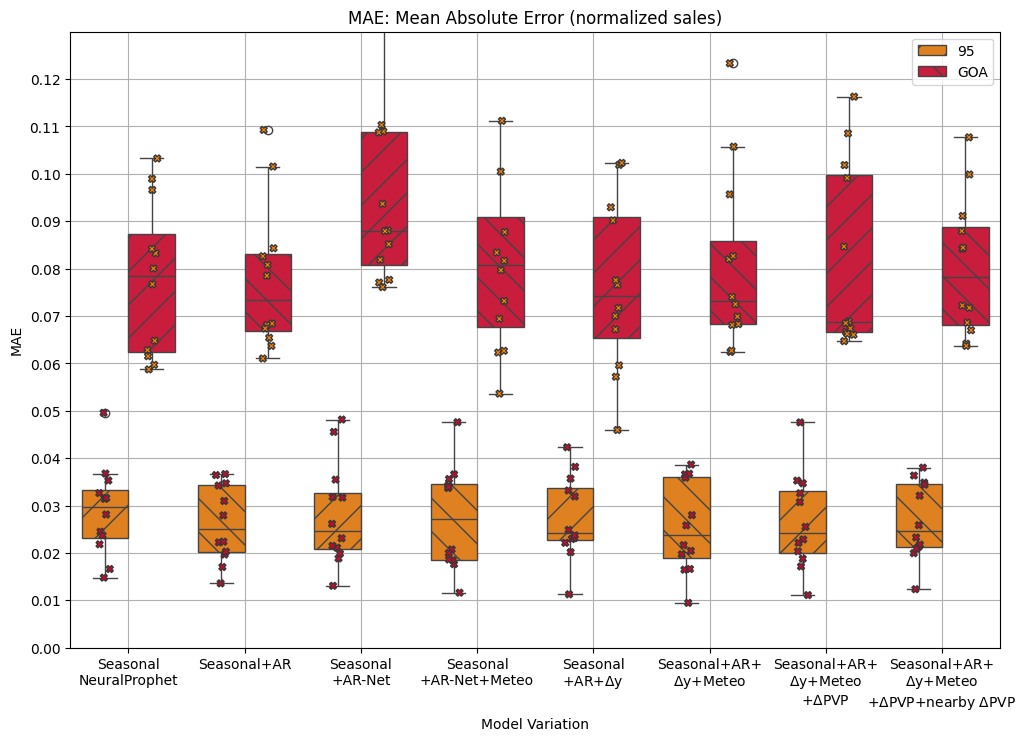

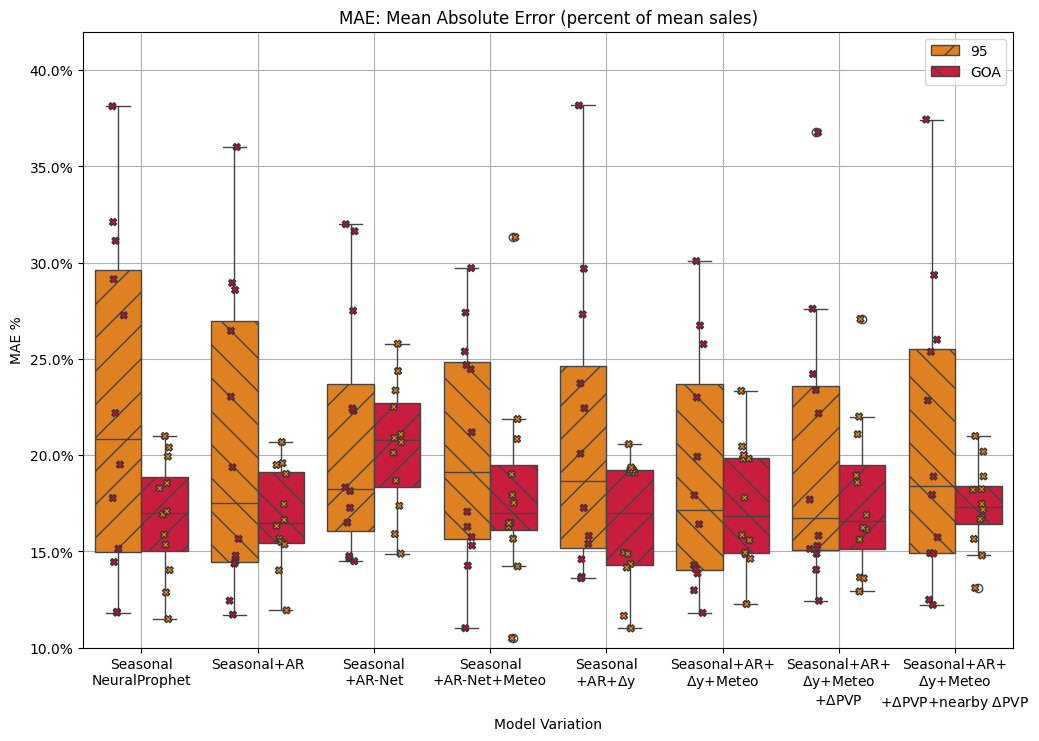

In [7]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)

snspal=sns.color_palette(palette='Dark2')
snspal2=sns.color_palette(palette='Reds_r',n_colors=2)

IZ_colors = ['#FF8200','#E4002B']

fig,ax=plt.subplots(1,1,figsize=(12,8))

sns.boxplot(x='model_name',y='mase_test2',data=df_res,hue='Product',ax=ax,palette=IZ_colors,order=ms)
hatches=['/','\\']
for k,ps in enumerate(ax.patches):
    ps.set_hatch(hatches[k%2])
ax.legend()

ax.set_ylim(0.3,1.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel('Model Variation');
ax.set_ylabel('MASE %')
ax.set_title('MASE: Mean Absolute Scaled Error (percent of naive forecast error)')
sns.stripplot(x='model_name',y='mase_test2',data=df_res,hue='Product',ax=ax,dodge=True,legend=False,
              marker='X',size=5,palette=[IZ_colors[1], IZ_colors[0]],edgecolor='#373737', linewidth=1,jitter=0.1)
ax.grid('both')
ax.set_yticks(np.arange(0.3,1.5,0.15))
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(12,8))

sns.boxplot(x='model_name',y='mae_test',data=df_res,hue='Product',ax=ax,palette=IZ_colors,order=ms)
hatches=['/','\\']
for k,ps in enumerate(ax.patches):
    ps.set_hatch(hatches[k%2])
ax.legend()

ax.set_ylim(0.0,0.13)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('MAE')
ax.set_xlabel('Model Variation');
ax.set_title('MAE: Mean Absolute Error (normalized sales)')
sns.stripplot(x='model_name',y='mae_test',data=df_res,hue='Product',ax=ax,dodge=True,legend=False,
              marker='X',size=5,palette=[IZ_colors[1], IZ_colors[0]],edgecolor='#373737', linewidth=1,jitter=0.1)
ax.grid('both')
ax.set_yticks(np.arange(0.0,.13,0.01))
ax.legend()


fig,ax=plt.subplots(1,1,figsize=(12,8))

sns.boxplot(x='model_name',y='mae_test_rel',data=df_res,hue='Product',ax=ax,palette=IZ_colors,order=ms)
hatches=['/','\\']
for k,ps in enumerate(ax.patches):
    ps.set_hatch(hatches[k%2])
ax.legend()

ax.set_ylim(0.1,0.42)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('MAE %')
ax.set_xlabel('Model Variation');
ax.set_title('MAE: Mean Absolute Error (percent of mean sales)')
sns.stripplot(x='model_name',y='mae_test_rel',data=df_res,hue='Product',ax=ax,dodge=True,legend=False,
              marker='X',size=5,palette=[IZ_colors[1], IZ_colors[0]],edgecolor='#373737', linewidth=1,jitter=0.1)
ax.grid('both')
ax.set_yticks(np.arange(0.1,.45,0.05))
ax.legend()



/content/drive/MyDrive/Colab Notebooks/Capstone/model_runs/m_7/ES10_95_forecast_test.pkl


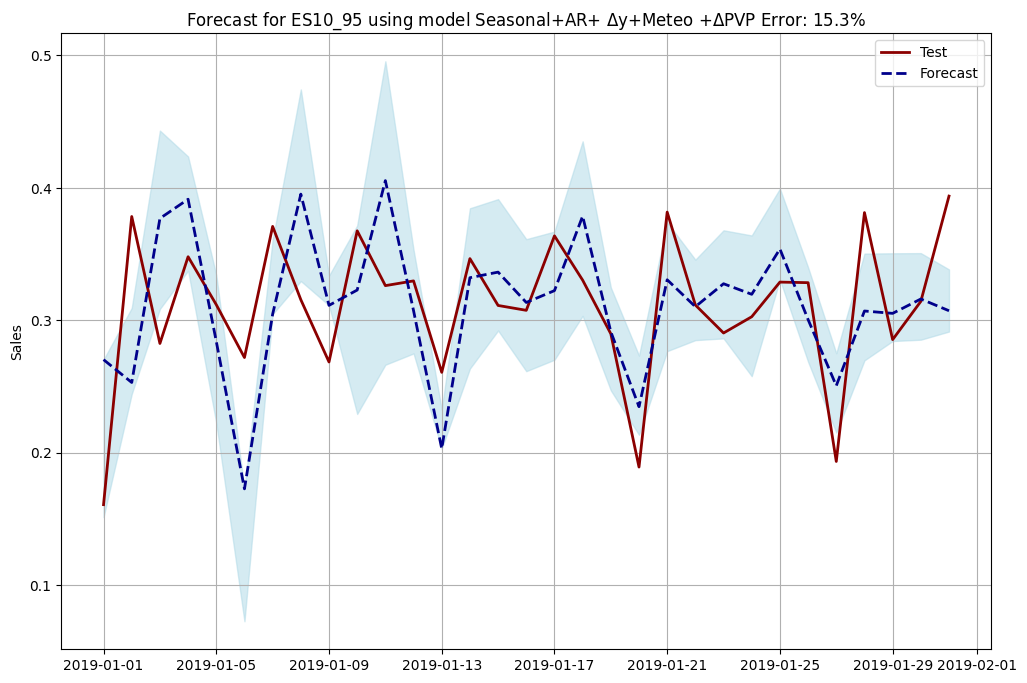

In [8]:
def plt_1d(df_1d,stn,model):

    df_1d=df_1d[df_1d.index>='2019-01-01'] # only plot test period jan 2019

    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.plot(df_1d.index,df_1d['y'],label='Test',color='darkred',lw=2)
    ax.plot(df_1d.index,df_1d['yhat1'],label='Forecast',color='darkblue',ls='--',lw=2)
    ax.fill_between(df_1d.index,df_1d['yhat1 5.0%'],df_1d['yhat1 95.0%'],color='lightblue',alpha=0.5)
    ax.grid('both')
    ax.legend()
    ax.set_ylabel('Sales')
    errorpct=(df_1d.yhat1-df_1d.y).abs().sum()/df_1d.y.sum()
    model_name=model_names[model].replace('\n',' ')
    ax.set_title(f"Forecast for {stn} using model {model_name} Error: {errorpct*100:.1f}%")
    return fig,ax


model=7
stn='ES10_95'

# daily forecast example forecast plot

fpathx=fpath
pkf=fpathx+f'/model_runs/m_{model}/{stn}_forecast_test.pkl'
print(pkf)
df1=pd.read_pickle(pkf)
df1

fig,ax=plt_1d(df1,stn,model)

plt.show()


## Month forecasts, for 2019-01 compared to test data

In [9]:
# load monthly results
fpathx=fpath+'/m31_runs'
df_yhat=pd.DataFrame(index=pd.date_range(freq='D',start='2019-01-01',end='2019-01-31'))
df_y=pd.DataFrame(index=pd.date_range(freq='D',start='2019-01-01',end='2019-01-31'))
reslist=[]
for i in range(1,9):
    pkl_files=glob.glob(fpathx+f'/m31_{i}/*.pkl')
    if len(pkl_files)==0:
        print("No pkls found!")
    else:
        for pkl_file in pkl_files:
            dd=pd.read_pickle(pkl_file)
            pkl_name=pkl_file.split(os.sep)[-1]
            stn=pkl_name.split('_')[0]+'_'+pkl_name.split('_')[1]
            df_yhat[stn]=dd['yhatn']
            df_y[stn]=dd['y']
            reslist.append([stn.split('_')[0],pkl_name.split('_')[1],i,df_y[stn].sum(),df_yhat[stn].sum(),(df_yhat[stn].sum()-df_y[stn].sum())/df_y[stn].sum()])


In [10]:
df_res=pd.DataFrame(data=reslist,columns=['Station','Product','model','total','totalhat','errorpct'])

model_names={1:'Seasonal\nNeuralProphet',2:'Seasonal+AR',3:'Seasonal\n+AR-Net',4:'Seasonal\n+AR-Net+Meteo',
             5:'Seasonal\n+AR+$\Delta$y',6:'Seasonal+AR+\n$\Delta$y+Meteo',
             7:'Seasonal+AR+\n$\Delta$y+Meteo\n+$\Delta$PVP',8:'Seasonal+AR+\n$\Delta$y+Meteo\n+$\Delta$PVP+nearby $\Delta$PVP'}

df_res['model_name']=df_res.model.map(model_names)
df_res['error']=df_res.totalhat-df_res.total


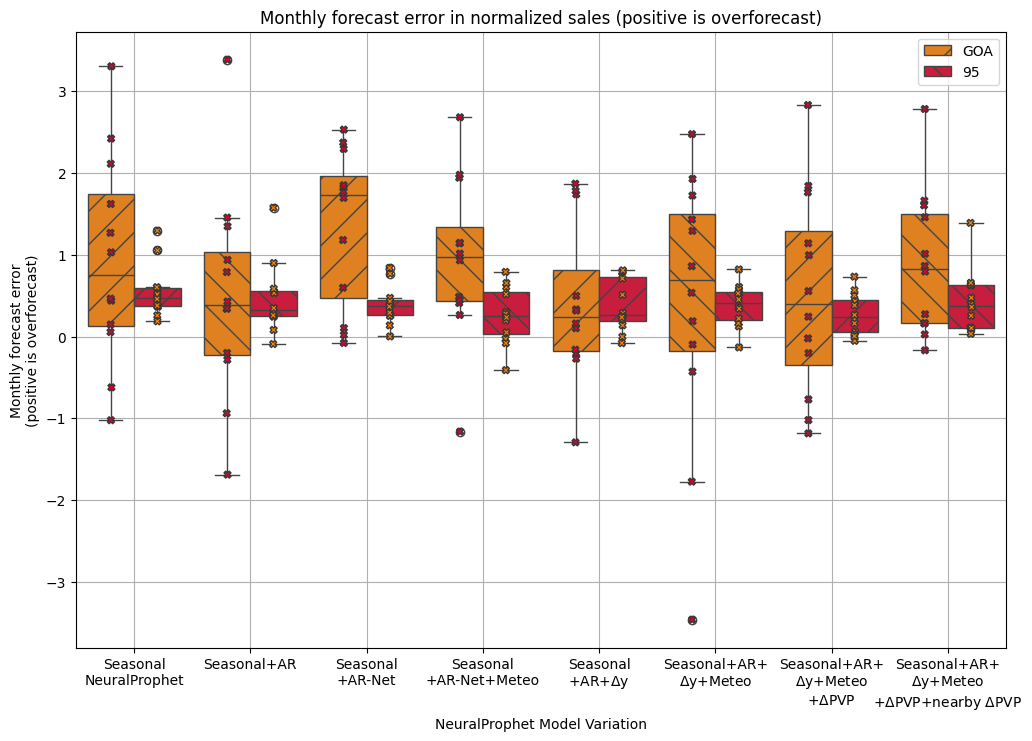

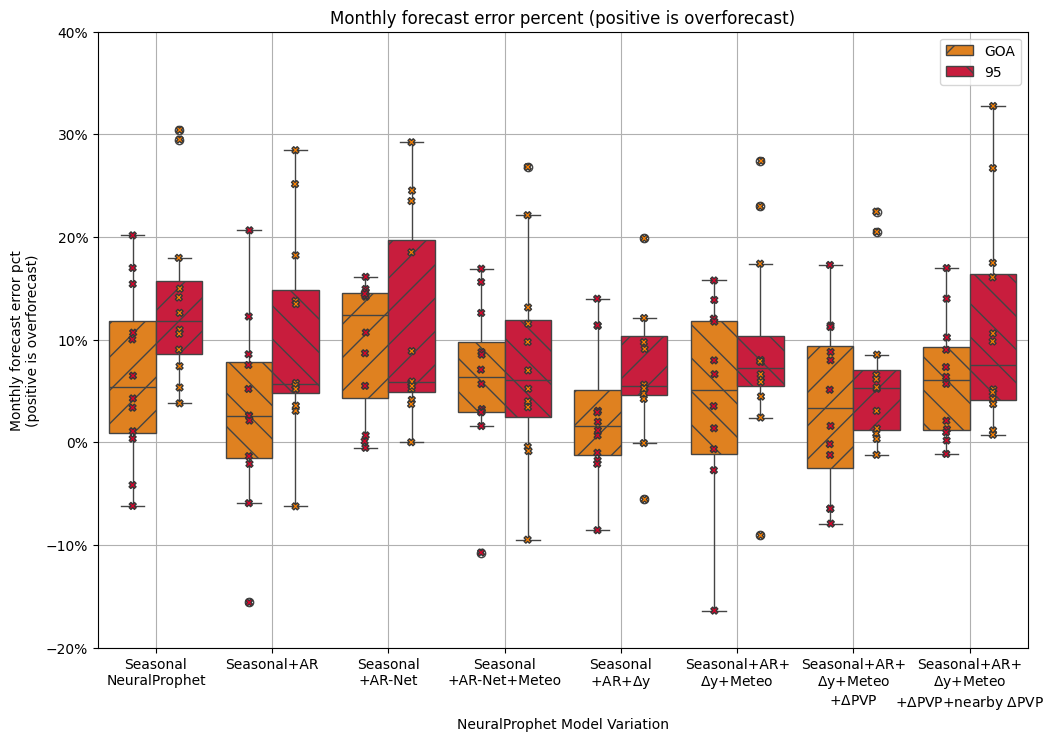

In [11]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)

# Repsol colors
IZ_colors = ['#FF8200','#E4002B']


# sum of forecast error [normalized sales]
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='model_name',y='error',data=df_res,hue='Product',ax=ax,palette=IZ_colors)
hatches=['/','\\']
for k,ps in enumerate(ax.patches):
    ps.set_hatch(hatches[k%2])
ax.legend()

#ax.set_ylim(-0.2,0.4)
ax.set_xlabel('NeuralProphet Model Variation');
ax.set_title('Monthly forecast error in normalized sales (positive is overforecast)')
sns.stripplot(x='model_name',y='error',data=df_res.dropna(),hue='Product',ax=ax,dodge=True,legend=False,
              marker='X',size=5,palette=[IZ_colors[1], IZ_colors[0]],edgecolor='#373737', linewidth=1,jitter=0.01)


ax.set_ylabel('Monthly forecast error\n(positive is overforecast)')

ax.grid('both')
ax.legend()

# Percentage error
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='model_name',y='errorpct',data=df_res,hue='Product',ax=ax,palette=IZ_colors)
hatches=['/','\\']
for k,ps in enumerate(ax.patches):
    ps.set_hatch(hatches[k%2])
ax.legend()

ax.set_ylim(-0.2,0.4)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel('NeuralProphet Model Variation');
ax.set_title('Monthly forecast error percent (positive is overforecast)')
sns.stripplot(x='model_name',y='errorpct',data=df_res.dropna(),hue='Product',ax=ax,dodge=True,legend=False,
              marker='X',size=5,palette=[IZ_colors[1], IZ_colors[0]],edgecolor='#373737', linewidth=1,jitter=0.01)

ax.set_ylabel('Monthly forecast error pct\n(positive is overforecast)')

ax.grid('both')
ax.legend()

In [12]:
import os

def plt_mth(df_mth,stn,model):

    fig,ax=plt.subplots(1,1,figsize=(12,8))
    ax.plot(df_mth.index,df_mth.y,label='Test',color='darkred',lw=2)
    ax.plot(df_mth.index,df_mth.yhatn,label='Forecast',color='darkblue',ls='--',lw=2)
    ax.fill_between(df_mth.index,df_mth['yhat lower'],df_mth['yhat upper'],color='lightblue',alpha=0.5)
    ax.grid('both')
    ax.legend()
    ax.set_ylabel('Sales')
    model_name=model_names[model].replace('\n',' ')
    ax.set_title(f"Forecast for {stn} using model {model_name}")
    errorpct=(df_mth.yhatn.sum()-df_mth.y.sum())/df_mth.y.sum()
    ax.set_title(f"Forecast for {stn} using model {model_name} Error: {errorpct*100:.1f}%")
    return fig,ax


def highlight_absmin(s):
    is_min = s.abs() == s.abs().min()
    return ['background-color: #FF8200;font-weight:bold' if v else '' for v in is_min]



In [13]:

print("95 31d forecast minimum abs error % for each station")
df_res.groupby(['Station','model','Product']).errorpct.min().unstack().unstack()['95']\
      .style.format('{:.1%}')\
      .apply(highlight_absmin,axis=1)

95 31d forecast minimum abs error % for each station


model,1,2,3,4,5,6,7,8
Station,,,,,,,,
ES1,12.6%,-6.2%,29.2%,3.4%,-5.5%,-9.1%,0.3%,26.7%
ES10,5.3%,5.5%,4.1%,-0.8%,5.3%,6.3%,5.2%,3.7%
ES11,10.6%,13.5%,0.0%,-9.5%,-0.1%,7.8%,-1.2%,0.7%
ES12,9.0%,5.2%,5.5%,9.8%,12.1%,7.9%,0.9%,9.8%
ES2,7.4%,5.2%,5.9%,4.0%,4.8%,4.5%,5.3%,5.2%
ES3,14.1%,3.1%,5.2%,11.6%,5.3%,17.4%,6.2%,4.2%
ES4,29.5%,25.2%,23.5%,22.1%,19.9%,23.0%,20.5%,17.5%
ES5,30.4%,28.5%,24.5%,26.8%,41.3%,27.4%,22.5%,32.8%
ES6,15.0%,18.2%,8.9%,7.0%,9.1%,6.6%,6.5%,16.1%


In [14]:

print("GOA 31d forecast minimum abs error % for each station")
df_res.groupby(['Station','model','Product']).errorpct.min().unstack().unstack()['GOA']\
      .style.format('{:.1%}')\
      .apply(highlight_absmin,axis=1)

GOA 31d forecast minimum abs error % for each station


model,1,2,3,4,5,6,7,8
Station,,,,,,,,
ES1,0.4%,5.2%,0.7%,2.9%,-8.6%,3.5%,1.6%,5.7%
ES10,15.4%,8.6%,16.1%,12.6%,11.4%,15.8%,11.2%,10.2%
ES11,1.1%,-2.1%,8.7%,3.0%,1.2%,1.4%,-0.2%,0.2%
ES12,20.2%,20.7%,14.5%,5.7%,11.4%,11.8%,17.3%,17.0%
ES2,3.4%,2.6%,14.3%,8.8%,-2.1%,6.6%,8.8%,2.1%
ES3,17.0%,7.5%,14.7%,15.6%,14.0%,13.9%,8.0%,1.3%
ES4,10.7%,12.3%,14.9%,8.5%,-1.8%,12.1%,-6.5%,14.0%
ES5,-6.2%,2.6%,0.1%,1.6%,2.0%,-20.9%,-1.2%,1.0%
ES6,10.0%,2.1%,14.2%,7.1%,3.1%,8.0%,11.4%,9.0%


Bad performance



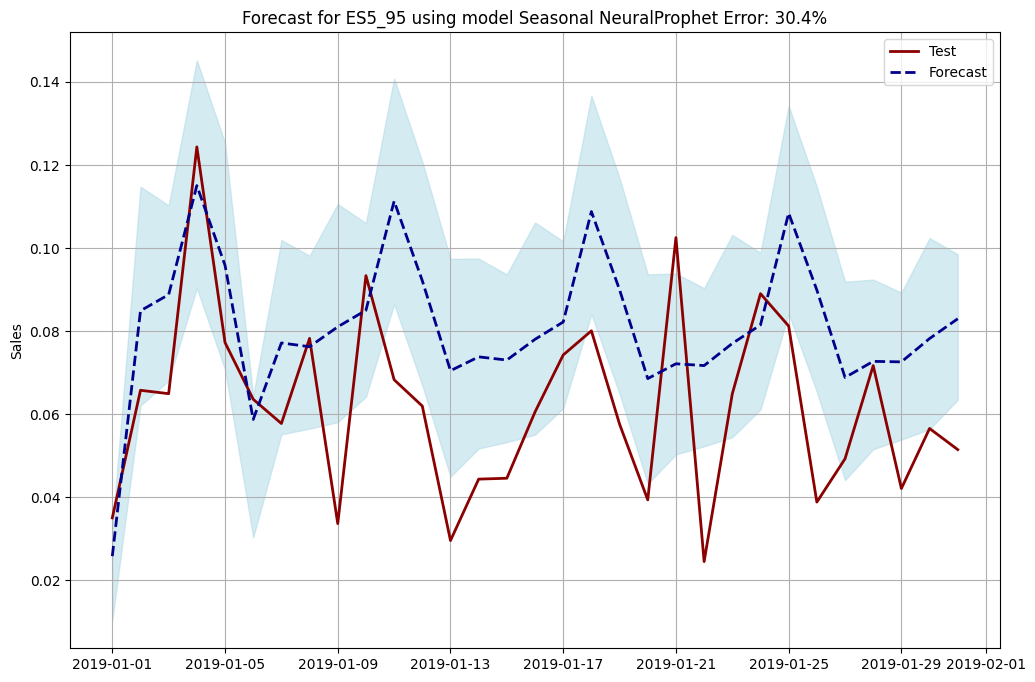


Better performance



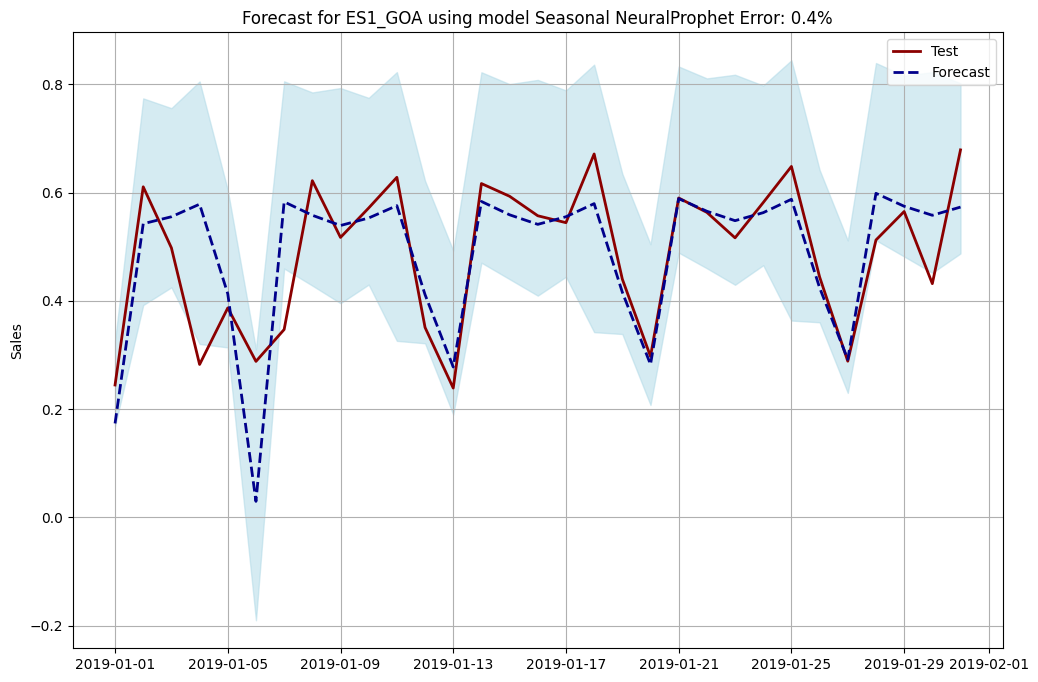

In [15]:
#ES10_95_model_6_f31d.pkl
# bad performance
stn='ES5_95'
model=1


fpathx=fpath
pkf=fpathx+f'/m31_runs/m31_{model}/{stn}_model_{model}_f31d.pkl'
df31=pd.read_pickle(pkf)
df31.rename(columns={'yhat1 5.0%':'yhat lower','yhat1 95.0%':'yhat upper'},inplace=True) #some results have different columns
print("Bad performance\n")
fig,ax=plt_mth(df31,stn,model)

plt.show()

# better performance
stn='ES1_GOA'
model=1
print("\nBetter performance\n")
pkf=fpathx+f'/m31_runs/m31_{model}/{stn}_model_{model}_f31d.pkl'
df31=pd.read_pickle(pkf)
df31.rename(columns={'yhat1 5.0%':'yhat lower','yhat1 95.0%':'yhat upper'},inplace=True) #some results have different columns

fig,ax=plt_mth(df31,stn,model)

plt.show()
